### Sample rate conversion with interpolation
In this notebook, we look at the process of interpolating a signal through upsampling followed by low-pass filtering and downsampling in order to change its sample rate. 

In [1]:
import numpy as np 
from scipy import signal
import sounddevice as sd
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
from IPython.core.display import display, HTML

Let's start once again by recording a signal! Say, scream, shout whatever you want (don't clip the mic. though)

In [12]:
duration = 3  # seconds
fs = 8000    # Sampling frequency (Hz)
print ('recording...')
y_8k = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')


recording...
finished recording


Check out the signal and listen to it. 

Audio at 8 kHz:


<IPython.core.display.Javascript object>


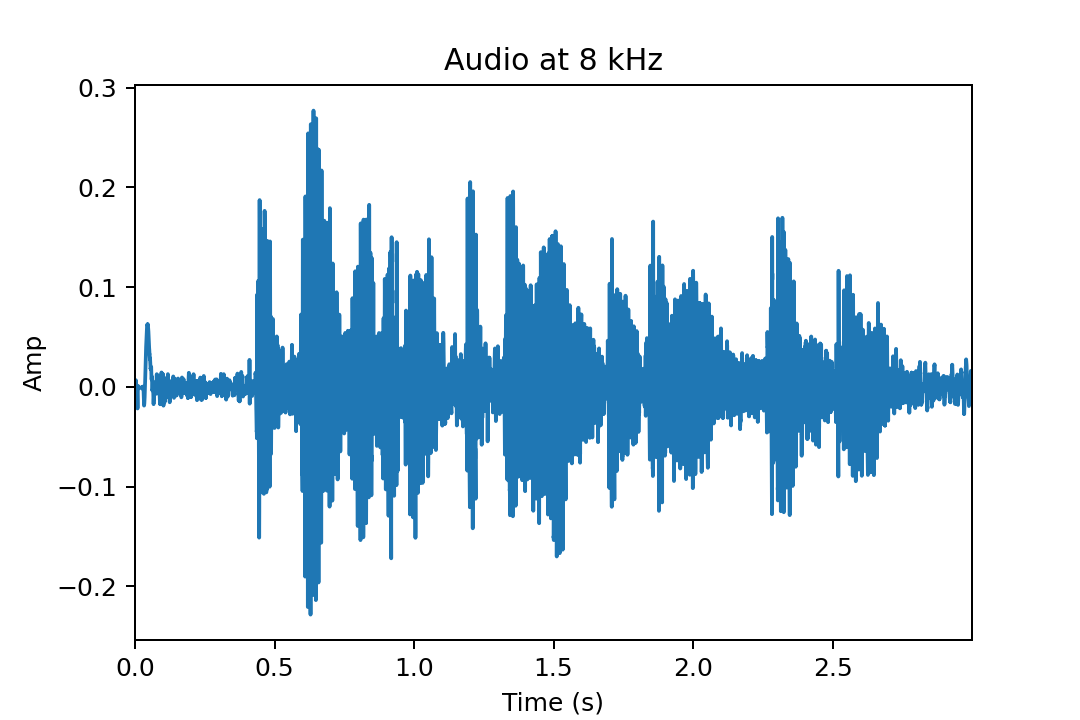

<IPython.core.display.Javascript object>


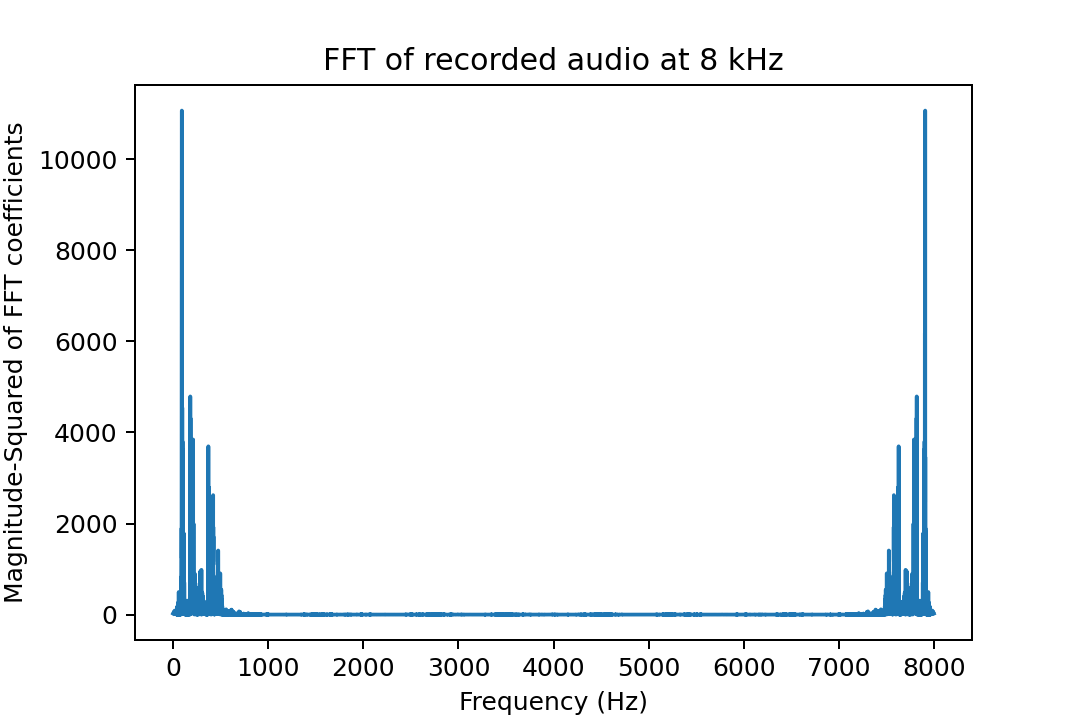

Text(0, 0.5, 'Magnitude-Squared of FFT coefficients')

In [16]:
print("Audio at 8 kHz:")
IPython.display.display(Audio(y_8k.T, rate=fs))

dt = 1/fs           
N = len(y_8k) 
time = np.arange(0,N*dt,dt)  

fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(time,y_8k)  #
axes.set_title('Audio at 8 kHz')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amp')
axes.set_xlim(time[0],time[-1])


# Fast Fourier Transform (FFT) of the signal
Y_8k = np.fft.fft(y_8k[:,0])

#Set up the frequency vector
df = fs/N  # the frequency bin spacing
freqs = np.arange(0,fs,df) # first value = DC, last value = fs-df. This means we are plotting the double-sided spectrum

fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(freqs,np.abs(Y_8k**2))
# axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_title('FFT of recorded audio at 8 kHz')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients')


Okay that looks reasonable. So if we want to re-sample this signal to a higher sample rate, we need to **interpolate** between the exisiting samples that are available to us. This can be achieved by doing two processes: (i) inserting zeros between samples, i.e. upsampling the signal by factor I or "zero-stuffing" as it is sometimes referred to, and (ii) downsampling or decimation of this upsampled signal by a factor D. The sample rate conversion factor is then V = I/D.

So if our original sample rate was 8kHz but we want to re-sample it to 16kHz, then V = 2. We have some liberty in choosing I and D to ensure V = 2. In the following let's try I = 8 and D = 4.

First up... the upsampling, let's go!

<IPython.core.display.Javascript object>


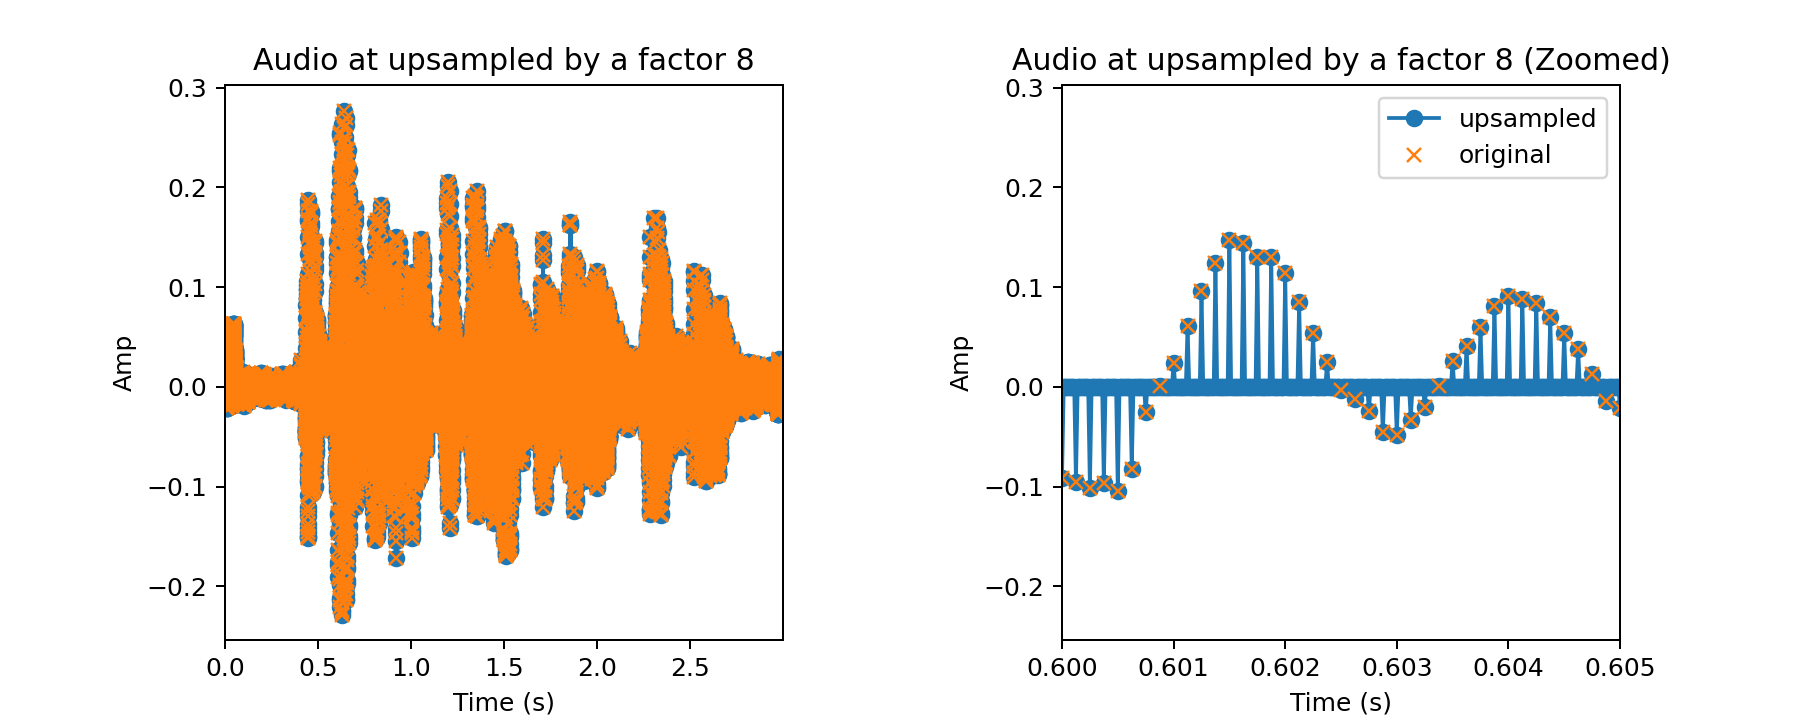

<IPython.core.display.Javascript object>


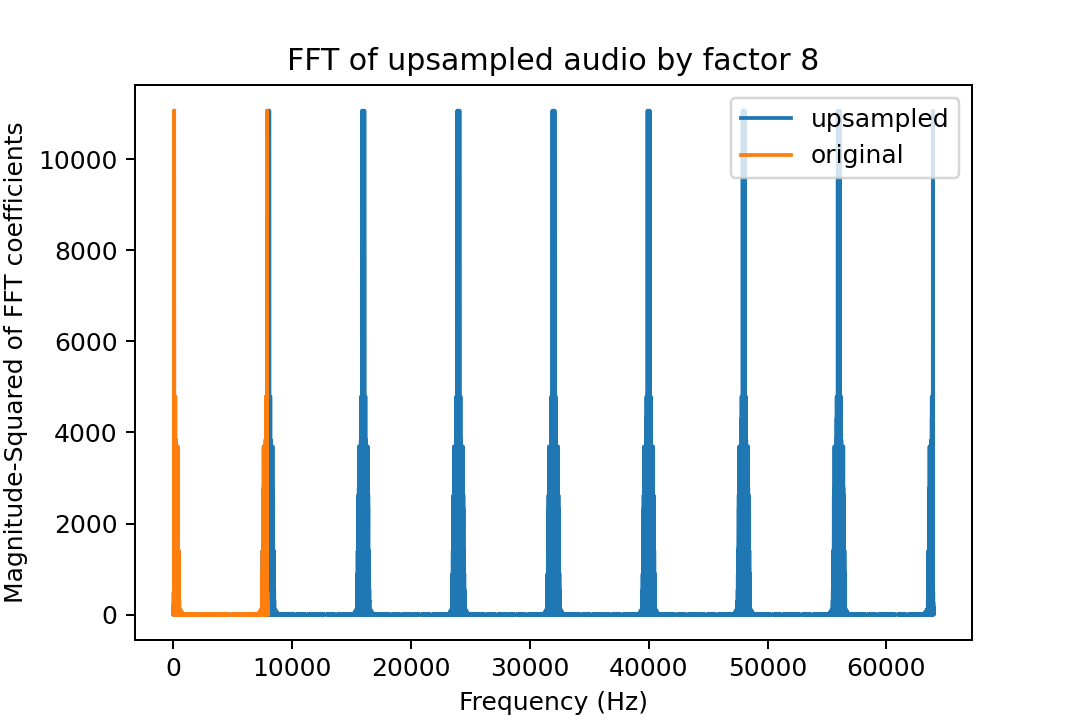

What does this upsampled signal sound like?
The upsampled sampling frequency is 64000Hz


In [37]:
I = 8        # Upsampling factor
N_ups = N*I  # Total number of samples in our upsampled signal
y_I = np.zeros(N_ups)

for m in range(N_ups):
    if (m%I)==0:  # modulo operation to check if index is a multiple of I
        R = m//I 
        y_I[m] = y_8k[R,0]
        
        

# Plotting
fs_I = fs*I  # The upsampled sampling freq 
dt_I = 1/fs_I           
time_I = np.arange(0,N_ups*dt_I,dt_I)  

# Time-domain signal
fig, axes = plt.subplots(1,2,figsize=(10, 4)) 
fig.subplots_adjust(wspace=0.5) # spacing between figures
axes[0].plot(time_I,y_I,label='upsampled',marker='o')  #
axes[0].plot(time,y_8k,label='original',marker='x',linestyle="None")  #
axes[0].set_title('Audio at upsampled by a factor ' + str(I))
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim(time[0],time[-1])
# plt.legend()

# Zoomed up on this figure to see what's going on
#fig, axes = plt.subplots(figsize=(6, 4)) 
axes[1].plot(time_I,y_I,label='upsampled',marker='o')  #
axes[1].plot(time,y_8k,label='original',marker='x',linestyle="None")  #
axes[1].set_title('Audio at upsampled by a factor ' + str(I)+' (Zoomed)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amp')
axes[1].set_xlim(0.6,0.605)
plt.legend()


# Fast Fourier Transform (FFT) of the upsampled signal
Y_I = np.fft.fft(y_I)

#Set up the frequency vector
df_I = fs_I/N_ups  # the frequency bin spacing
freqs_I = np.arange(0,fs_I,df_I) # first value = DC, last value = fs-df. This means we are plotting the double-sided spectrum

# Check out that spectrum repetition!
fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(freqs_I,np.abs(Y_I**2),label='upsampled')
axes.plot(freqs,np.abs(Y_8k**2),label='original')
# axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_title('FFT of upsampled audio by factor ' + str(I))
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients')        
plt.legend()

print('What does this upsampled signal sound like?')
print('The upsampled sampling frequency is '+str(fs_I)+ 'Hz')
IPython.display.display(Audio(y_I, rate=fs_I))




Alright we did some upsampling, but the  signal is clearly distorted. We see it both in the spectrum (the extra spectral images above 8kHz) and we can hear it. So we clearly need to do some filtering. If we want to get rid of all of these extra spectral images, but maintain the same spectral content as the original signal. Therefore we would need to apply a low pass filter where everything above fs/2 is set to zero (fs being the original sample rate of the signal). 

<IPython.core.display.Javascript object>


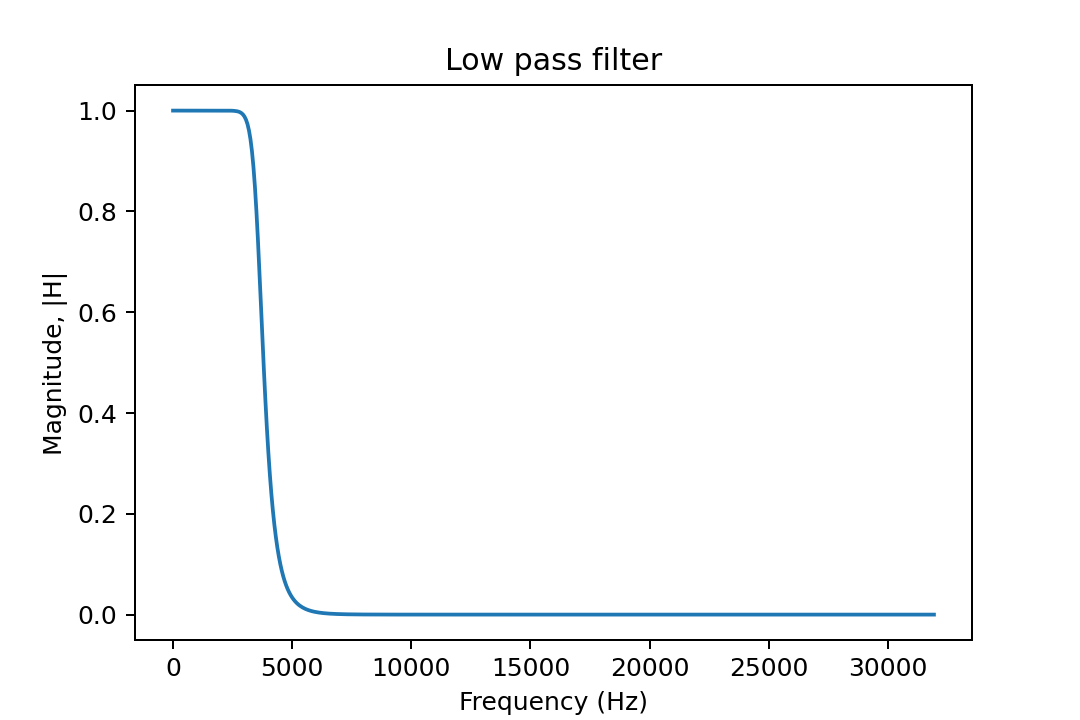

<IPython.core.display.Javascript object>


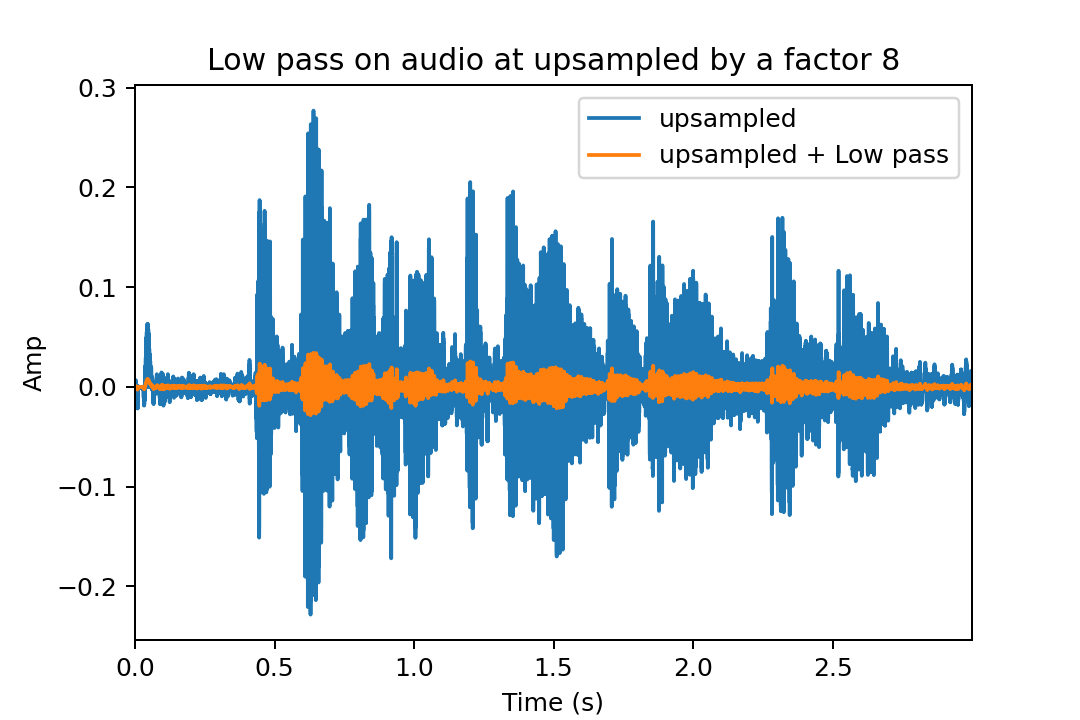

<IPython.core.display.Javascript object>


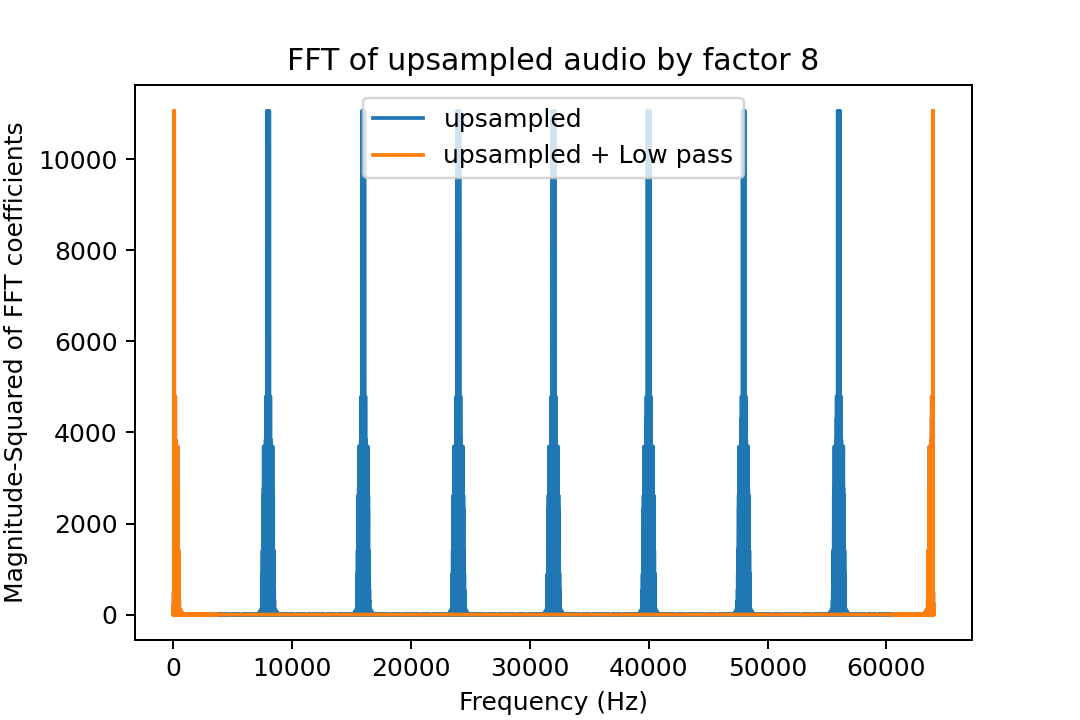

What does this upsampled, low pass signal sound like?


In [39]:
# Design the low pass filter:
fc = 0.9*(fs/2)  # cut-off freq (Hz), make it just before fs/2, since this is the -3dB point of the butterworth filter
Ord = 10    # Filter order
b_lp, a_lp = signal.butter(Ord, fc, 'low', fs=fs_I)
w_lp, H_lp = signal.freqz(b_lp, a_lp, fs=fs_I)      # freq response

fig, ax = plt.subplots(figsize=(6, 4)) 
ax.plot(w_lp, abs(H_lp))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude, |H|')
ax.set_title('Low pass filter')


# Filter the upsampled signal and do FFT:
y_I_lpf = signal.lfilter(b_lp,a_lp, y_I)
Y_I_lpf = np.fft.fft(y_I_lpf)


fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(time_I,y_I,label='upsampled')  #
axes.plot(time_I,y_I_lpf,label='upsampled + Low pass')  #
axes.set_title('Low pass on audio at upsampled by a factor ' + str(I))
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amp')
axes.set_xlim(time[0],time[-1])
plt.legend()

fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(freqs_I,np.abs(Y_I**2),label='upsampled')
axes.plot(freqs_I,np.abs(Y_I_lpf**2),label='upsampled + Low pass')
# axes.plot(freqs,np.abs(Y_8k**2),label='original')
# axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_title('FFT of upsampled audio by factor ' + str(I))
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients')        
plt.legend()

print('What does this upsampled, low pass signal sound like?')
IPython.display.display(Audio(y_I_lpf, rate=fs_I))






Sounds much better! But wait a minute, why has the amplitude of the signal been reduced? Simply because we have filtered out quite a bit of energy from the upsampled signal. We have essentially filtered out approximately a factor of 1/I of the energy of the upsampled signal, so we need to compensate for this, which we can do by rescaling our filtered signal with a factor of approximately I. The exact factor however can be computed from the ratio of the mean square of the upsampled signal to the mean square of the filtered signal (i.e. we ensure that the energy of the signal is conserved). This factor is slightly different from I as it takes into account the actual filter characteristics. Recall that the low-pass filter used was not an 'ideal' filter. But we will talk more about filters in a later lecture. You will also see that the low-pass filtered signal is slightly delayed from the upsampled signal, which is due to the group delay of the filter, but let's save that discussion for when we talk more about filters. 

Ratio of mean square of upsampled to low-pass filtered signal: 8.011011209613065


<IPython.core.display.Javascript object>


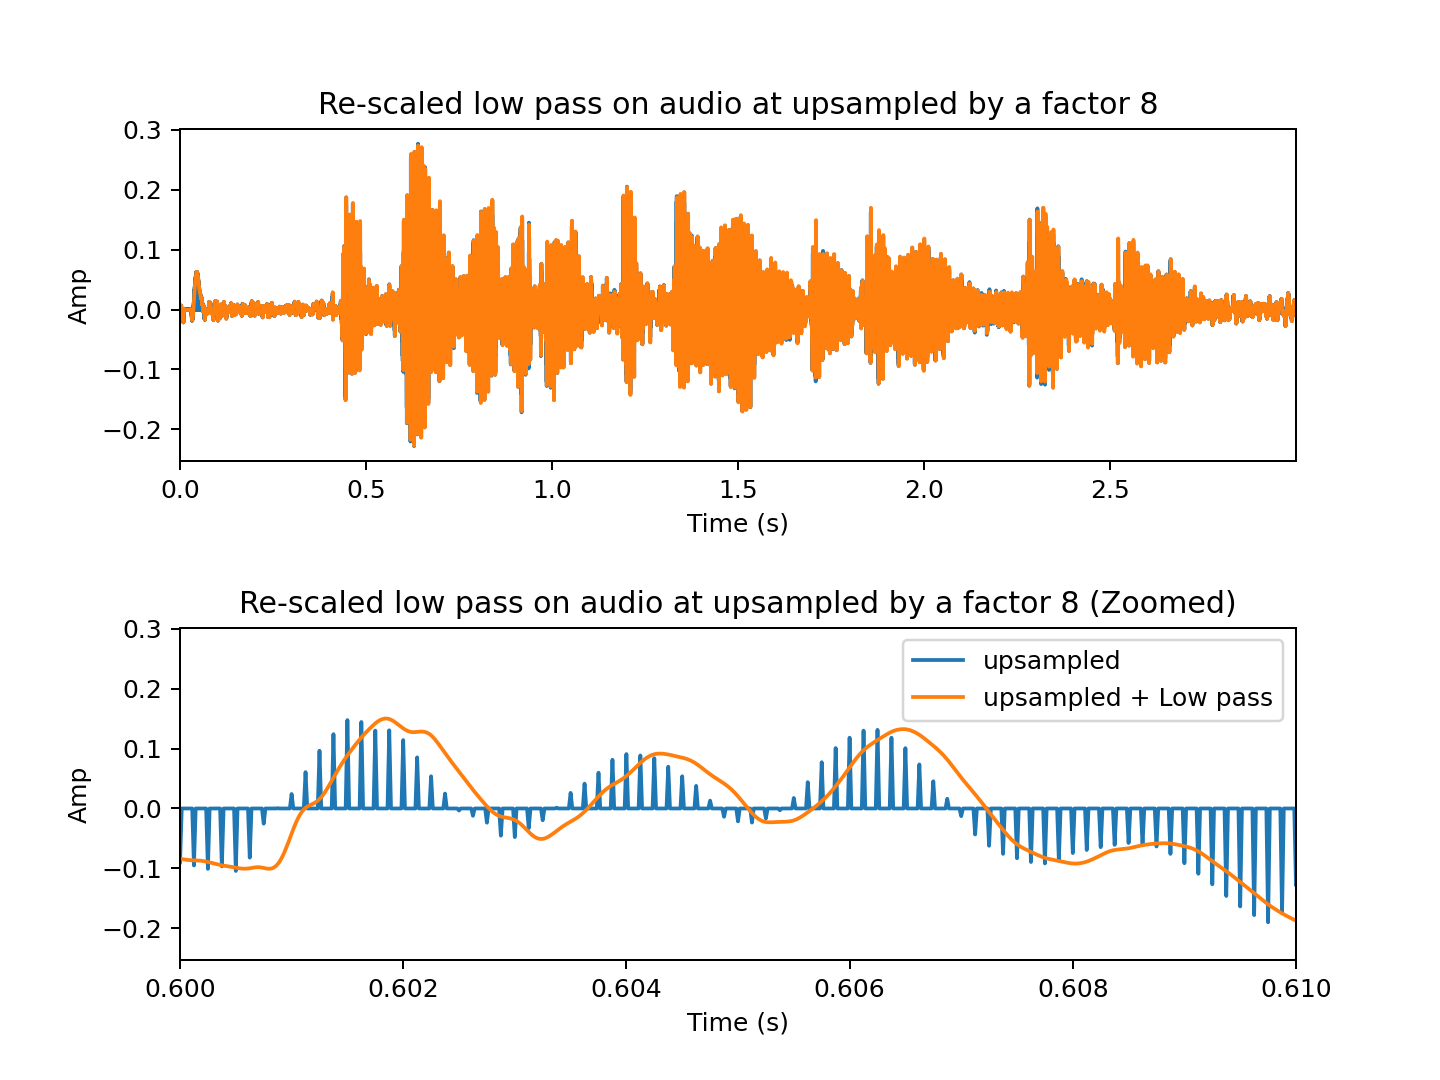

In [50]:
y_I_ms = ((np.mean(y_I**2))) # mean square of upsampled signal
y_I_lpf_ms = ((np.mean(y_I_lpf**2))) # mean square of low-pass filtered signal
I_app = (y_I_ms/y_I_lpf_ms) # This value should be very close to I
y_I_lpf_rescaled = I_app*y_I_lpf

print("Ratio of mean square of upsampled to low-pass filtered signal: "+ str(I_app))


fig, axes = plt.subplots(2,1,figsize=(8, 6)) 
fig.subplots_adjust(hspace=0.5) # spacing between figures
axes[0].plot(time_I,y_I,label='upsampled')  
axes[0].plot(time_I,y_I_lpf_rescaled,label='upsampled + Low pass')  #
axes[0].set_title('Re-scaled low pass on audio at upsampled by a factor ' + str(I))
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim(time[0],time[-1])
# plt.legend()

axes[1].plot(time_I,y_I,label='upsampled')  
axes[1].plot(time_I,y_I_lpf_rescaled,label='upsampled + Low pass')  #
axes[1].set_title('Re-scaled low pass on audio at upsampled by a factor ' + str(I)+' (Zoomed)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amp')
axes[1].set_xlim(0.6,0.61)
plt.legend()


To complete the resampling operation, now we decimate or downsample. Since we wanted the new sample rate to be twice the old one, we need to downsample by a factor of 4, i.e. D=4. We pretty much need to do the opposite of what we did when we upsampled the signal. We go through the upsampled, low-pass filtered signal and keep every D samples. 

Note that due to our rescaling in the previous stage, we preserve the signal energy. You will notice that when we plot the spectrum, that the magnitude of the coefficients are larger - why do you think that is the case?

<IPython.core.display.Javascript object>


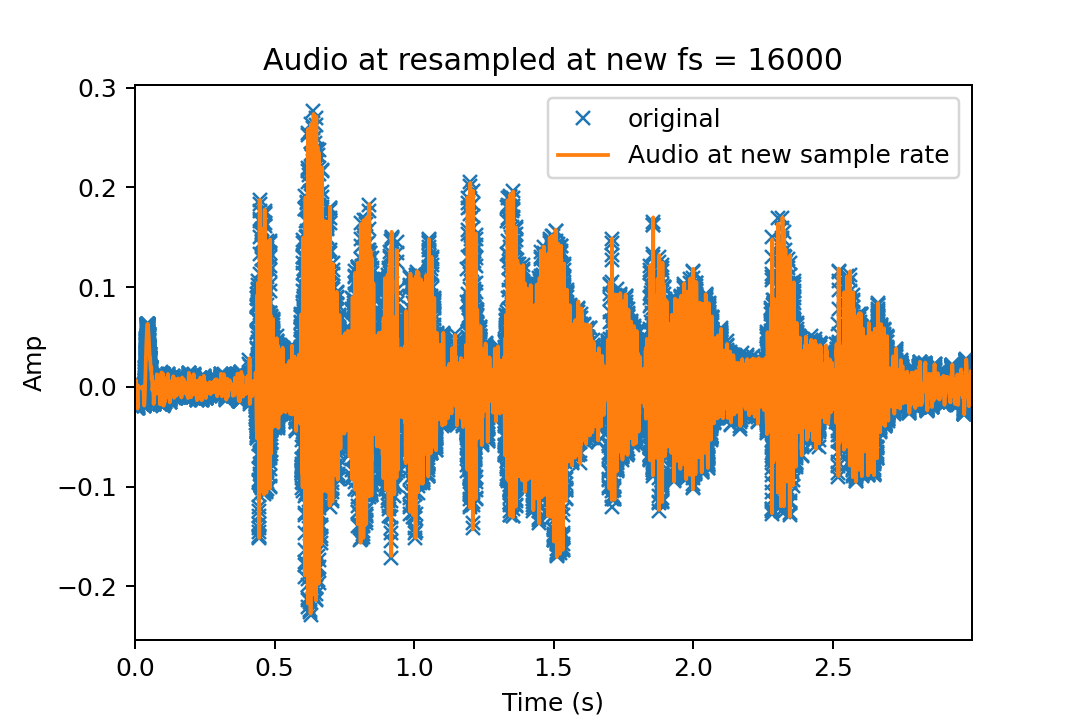

<IPython.core.display.Javascript object>


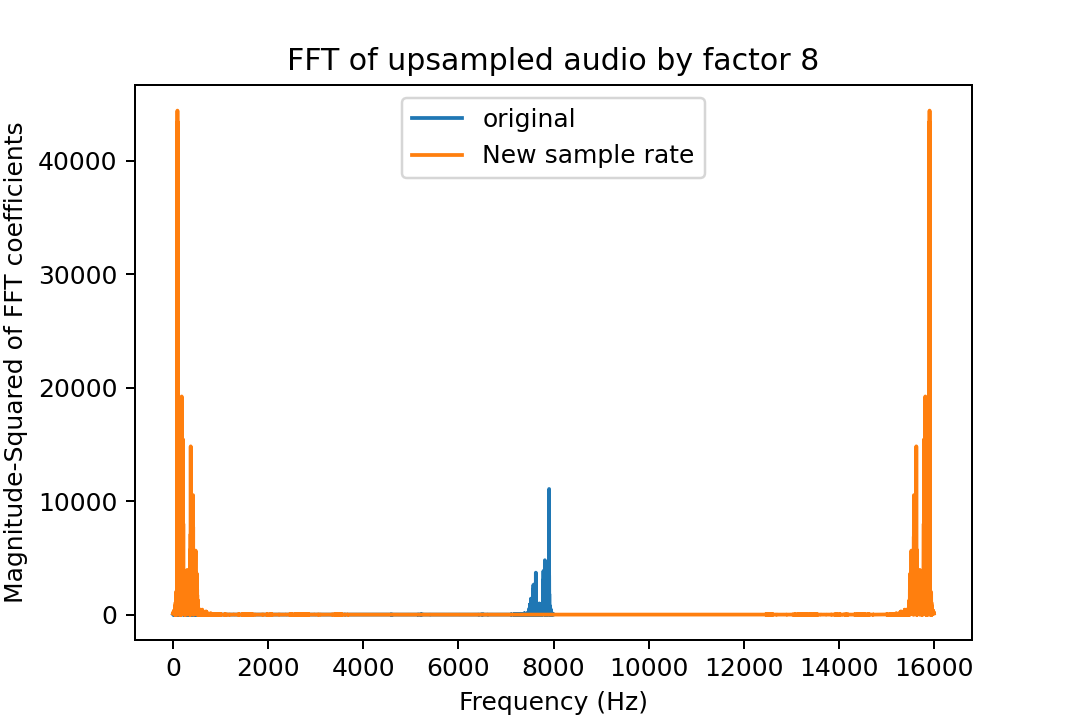

Mean square of 8k signal: 0.0019338035
Mean square of 16k signal: 0.0019364645435052058
Audio now at 16 kHz! Yay!


In [53]:
D = 4         # Downsampling factor
V = I//D      # Sample rate conversion factor
N_nsr = N*V   # Total number of samples in our signal with new sample rate
y_nsr = np.zeros(N_nsr)

for m in range(N_ups):
    if (m%D)==0:  # modulo operation to check if index is a multiple of I
        y_nsr[m//D] = y_I_lpf_rescaled[m]

# Plotting
fs_nsr = fs*V  # The new sampling freq 
dt_nsr = 1/fs_nsr           
time_nsr = np.arange(0,N_nsr*dt_nsr,dt_nsr)  

fig, axes = plt.subplots(figsize=(6, 4)) 
# axes.plot(time_I,y_I,label='upsampled',marker='o')  #
axes.plot(time,y_8k,label='original',marker='x',linestyle="None")  #
axes.plot(time_nsr,y_nsr,label='Audio at new sample rate')  #
axes.set_title('Audio at resampled at new fs = ' + str(fs*V))
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amp')
axes.set_xlim(time[0],time[-1])
plt.legend()



#FFT
Y_nsr = np.fft.fft(y_nsr)
df_nsr = fs_nsr/N_nsr  # the frequency bin spacing
freqs_nsr = np.arange(0,fs_nsr,df_nsr) # first value = DC, last value = fs-df. This means we are plotting the double-sided spectrum


fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(freqs,np.abs(Y_8k**2),label='original')
axes.plot(freqs_nsr,np.abs(Y_nsr**2),label='New sample rate')
# axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_title('FFT of upsampled audio by factor ' + str(I))
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients')        
plt.legend()

y_8k_ms = ((np.mean(y_8k**2))) # mean square of 8k signal
y_16k_ms = ((np.mean(y_nsr**2))) # mean square of signal resampled at 16k

print("Mean square of 8k signal: "+ str(y_8k_ms))
print("Mean square of 16k signal: "+ str(y_16k_ms))

# Hint on why spectrum looks the way it does:
# Sxx = (1/(N*dt))*(np.abs(Y_8k*dt)**2)
# print(np.sum(Sxx)*df)
# Sxx = (1/(N_nsr*dt_nsr))*(np.abs(Y_nsr*dt_nsr)**2)
# print(np.sum(Sxx)*df_nsr)


print('Audio now at 16 kHz! Yay!')
IPython.display.display(Audio(y_nsr, rate=fs_nsr))
